# Deep Reinforcement Learning for Financial Decision Making

This notebook demonstrates how to train and evaluate a deep reinforcement learning agent for optimal financial decision making using the life-model package.

## Setup and Installation

First, ensure you have installed the required dependencies:
```bash
pip install -e . -r deepqlearning/requirements-rl.txt
```

In [1]:
# Import required libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path

# Add the src directory to Python path if needed
if 'src' not in sys.path:
    sys.path.append('src')

# Output directory for models, results, and plots
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

from environment import FinancialLifeEnv, FinancialLifeEnvGenerator
from agent import FinancialDQNAgent, FinancialDQNTrainer
from actions import ActionType

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.2.2
CUDA available: False
Device: cpu


## Environment Setup

Let's create a financial environment and explore its structure.

In [2]:
# Create a basic financial environment
env = FinancialLifeEnvGenerator.create_basic_env()

print(f"Environment created successfully!")
print(f"State space size: {env.observation_space.shape[0]}")
print(f"Action space size: {env.action_space['action_type'].n}")
print(f"Max simulation steps: {env.max_steps}")

# Reset environment and examine initial state
initial_state = env.reset()
print(f"\nInitial state shape: {initial_state.shape}")
print(f"Initial state values: {initial_state[:10]}...")  # First 10 values

# Check initial financial situation
print(f"\nInitial Financial Situation:")
print(f"Age: {env.person.age}")
print(f"Bank Balance: ${env.person.bank_account_balance:,.2f}")
print(f"Annual Income: ${sum(job.salary.base for job in env.person.jobs):,.2f}")
print(f"Annual Spending: ${env.person.spending.get_yearly_spending():,.2f}")
print(f"Net Worth: ${env._calculate_net_worth():,.2f}")

Environment created successfully!
State space size: 20
Action space size: 29
Max simulation steps: 94

Initial state shape: (20,)
Initial state values: [0.25     0.8      0.       0.001776 0.01     0.       0.       0.
 0.05     0.03    ]...

Initial Financial Situation:
Age: 25
Bank Balance: $10,000.00
Annual Income: $50,000.00
Annual Spending: $30,000.00
Net Worth: $10,000.00


## Action Space Exploration

Let's examine the available actions the agent can take.

Display all available actions:

In [3]:
print("Available Financial Actions:")
for i, action_type in enumerate(ActionType):
    print(f"{i:2d}. {action_type.value}")

Available Financial Actions:
 0. transfer_bank_to_401k_pretax
 1. transfer_bank_to_401k_roth
 2. transfer_bank_to_ira_traditional
 3. transfer_bank_to_ira_roth
 4. transfer_bank_to_brokerage
 5. transfer_bank_to_hsa
 6. withdraw_401k_pretax
 7. withdraw_401k_roth
 8. withdraw_ira_traditional
 9. withdraw_ira_roth
10. withdraw_brokerage
11. withdraw_hsa
12. convert_401k_pretax_to_roth
13. convert_ira_traditional_to_roth
14. pay_extra_mortgage
15. pay_extra_credit_card
16. pay_extra_student_loan
17. pay_extra_car_loan
18. increase_spending
19. decrease_spending
20. retire_early
21. buy_house
22. sell_house
23. refinance_mortgage
24. change_401k_allocation
25. change_investment_strategy
26. buy_life_insurance
27. cancel_life_insurance
28. no_action


Display actions available in initial state:

In [4]:
print("Actions available to Agent in the initial state:")
for i, action_idx in enumerate(env.get_legal_actions()):
    action_type = list(ActionType)[action_idx]
    print(f"{i:2d}. {action_type.value}")

Actions available to Agent in the initial state:
 0. transfer_bank_to_brokerage
 1. increase_spending
 2. decrease_spending
 3. no_action


## Random Agent Baseline

Let's create a baseline by running random actions for a few episodes.

In [5]:
def run_random_episode(env, render=False):
    """Run one episode with random actions"""
    state = env.reset()
    total_reward = 0
    steps = 0
    episode_info = []

    while steps < env.max_steps:
        # Get legal actions and select random one
        legal_actions = env.get_legal_actions()
        action_type = np.random.choice(legal_actions)

        # Random amount percentage (0-30%)
        amount_percentage = np.array([np.random.uniform(0, 0.3)])

        action = {
            'action_type': action_type,
            'amount_percentage': amount_percentage
        }

        # Take action
        state, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1

        if render and steps % 10 == 0:  # Print every 10 steps
            print(f"Step {steps:2d}: Age {info['age']:2d}, "
                  f"Net Worth ${info['net_worth']:8,.0f}, "
                  f"Action: {info['action_type']}")

        episode_info.append(info)

        if done:
            break

    return total_reward, episode_info

# Run a few random episodes
print("Running random baseline episodes...")
random_rewards = []
for episode in range(5):
    reward, info = run_random_episode(env, render=(episode == 0))
    random_rewards.append(reward)
    final_info = info[-1] if info else {}
    print(f"Episode {episode + 1}: Reward = {reward:8.2f}, "
          f"Final Net Worth = ${final_info.get('net_worth', 0):,.0f}")

print(f"\nRandom baseline - Average reward: {np.mean(random_rewards):.2f} ± {np.std(random_rewards):.2f}")

Running random baseline episodes...
Step 10: Age 35, Net Worth $ 129,084, Action: transfer_bank_to_brokerage
Episode 1: Reward =    -1.88, Final Net Worth = $268,259
Episode 2: Reward =    15.51, Final Net Worth = $881,595
Episode 3: Reward =     7.86, Final Net Worth = $179,966
Episode 4: Reward =    12.02, Final Net Worth = $537,331
Episode 5: Reward =     4.38, Final Net Worth = $849,928

Random baseline - Average reward: 7.58 ± 6.04


## Create and Train DQN Agent

Now let's create and train a DQN agent to learn optimal financial strategies.

In [6]:
# Create a fresh environment for training
train_env = FinancialLifeEnvGenerator.create_basic_env()

# Get environment dimensions
state_size = train_env.observation_space.shape[0]
action_size = train_env.action_space['action_type'].n

print(f"Creating DQN agent with state_size={state_size}, action_size={action_size}")

# Configure agent for notebook training (smaller network, fewer episodes)
agent_config = {
    'learning_rate': 1e-3,  # Slightly higher for faster learning
    'batch_size': 32,       # Smaller batch size
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_end': 0.1,     # Higher final epsilon for more exploration
    'epsilon_decay': 0.99,  # Faster decay
    'target_update_freq': 50,  # More frequent updates
    'replay_buffer_size': 10000,  # Smaller buffer
    'min_replay_size': 500,     # Start training sooner
    'hidden_sizes': [256, 128], # Smaller network
    'use_dueling': True,
    'use_double_dqn': True
}

# Create agent
agent = FinancialDQNAgent(state_size, action_size, agent_config)

# Configure training (shorter for notebook)
num_episodes = int(os.getenv('NUM_EPISODES', 200))  # Use environment variable or default to 200
training_config = {
    'num_episodes': num_episodes, # Reduced for notebook
    'save_freq': 50,
    'eval_freq': 25,
    'eval_episodes': 3,
    'print_freq': 10,
    'model_save_path': model_dir / 'notebook_financial_dqn.pt'
}

# Create trainer
trainer = FinancialDQNTrainer(train_env, agent, training_config)

print("Training setup complete!")

Creating DQN agent with state_size=20, action_size=29
Initialized DQN Agent on cpu
Network architecture: [256, 128]
Using Dueling DQN: True
Using Double DQN: True
Training setup complete!


In [7]:
# Train the agent
print("Starting training...")
trainer.train()
print("Training completed!")

Starting training...
Starting training for 200 episodes
Environment: FinancialLifeEnv
Action space size: 29
State space size: 20
Episode    0, Reward:     6.34, Avg Reward (100):     6.34, Epsilon: 1.0000
Episode   10, Reward:    10.33, Avg Reward (100):     4.52, Epsilon: 0.4566
Episode   20, Reward:    35.07, Avg Reward (100):     9.20, Epsilon: 0.0991
  Eval Summary: Natural deaths: 3/3, Bankruptcies: 0/3, Successful completions: 0/3, Avg age at death: 78.3
Evaluation at episode 25: 40.59
Episode   30, Reward:   -12.18, Avg Reward (100):    14.39, Epsilon: 0.0991
Episode   40, Reward:    43.67, Avg Reward (100):    17.71, Epsilon: 0.0991
Episode   50, Reward:    49.43, Avg Reward (100):    20.43, Epsilon: 0.0991
  Eval Summary: Natural deaths: 3/3, Bankruptcies: 0/3, Successful completions: 0/3, Avg age at death: 84.3
Evaluation at episode 50: 45.05
Model saved to models/notebook_financial_dqn.pt
Episode   60, Reward:   -13.81, Avg Reward (100):    21.57, Epsilon: 0.0991
Episode   7

## Analyze Training Results

Let's visualize the training progress and analyze the agent's performance.

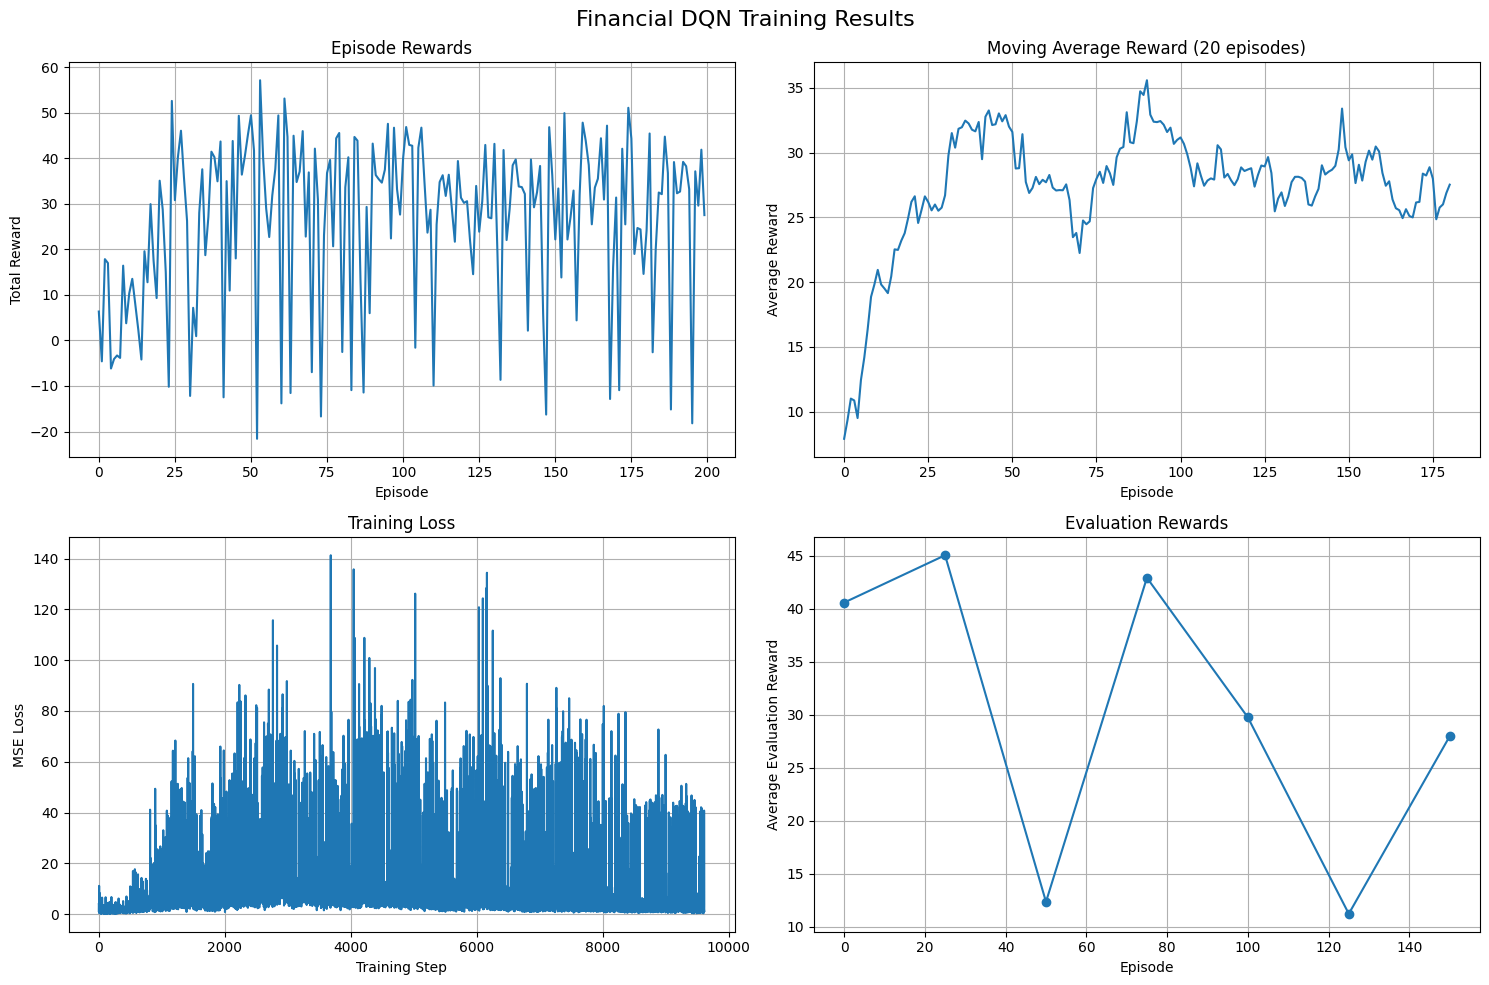


Training Statistics:
Total episodes: 200
Final epsilon: 0.0991
Total training steps: 9614
Average reward (last 50 episodes): 28.09
Best evaluation reward: 45.05
Final evaluation reward: 27.98


In [8]:
# Plot training results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Financial DQN Training Results', fontsize=16)

# Episode rewards
axes[0, 0].plot(trainer.episode_rewards)
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(True)

# Moving average of rewards
if len(trainer.episode_rewards) > 20:
    window = min(20, len(trainer.episode_rewards) // 4)
    moving_avg = np.convolve(trainer.episode_rewards, np.ones(window)/window, mode='valid')
    axes[0, 1].plot(moving_avg)
    axes[0, 1].set_title(f'Moving Average Reward ({window} episodes)')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Average Reward')
    axes[0, 1].grid(True)

# Training loss
if trainer.agent.training_losses:
    axes[1, 0].plot(trainer.agent.training_losses)
    axes[1, 0].set_title('Training Loss')
    axes[1, 0].set_xlabel('Training Step')
    axes[1, 0].set_ylabel('MSE Loss')
    axes[1, 0].grid(True)

# Evaluation rewards
if trainer.eval_rewards:
    eval_episodes = np.arange(len(trainer.eval_rewards)) * trainer.config['eval_freq']
    axes[1, 1].plot(eval_episodes, trainer.eval_rewards, 'o-')
    axes[1, 1].set_title('Evaluation Rewards')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Average Evaluation Reward')
    axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print training statistics
print(f"\nTraining Statistics:")
print(f"Total episodes: {len(trainer.episode_rewards)}")
print(f"Final epsilon: {agent.epsilon:.4f}")
print(f"Total training steps: {agent.steps_done}")
print(f"Average reward (last 50 episodes): {np.mean(trainer.episode_rewards[-50:]):.2f}")
if trainer.eval_rewards:
    print(f"Best evaluation reward: {max(trainer.eval_rewards):.2f}")
    print(f"Final evaluation reward: {trainer.eval_rewards[-1]:.2f}")

## Evaluate Trained Agent

Let's test the trained agent and compare it to the random baseline.

In [9]:
def run_trained_episode(env, agent, render=False):
    """Run one episode with trained agent"""
    state = env.reset()
    total_reward = 0
    steps = 0
    episode_info = []

    while steps < env.max_steps:
        # Get legal actions and select using trained agent
        legal_actions = env.get_legal_actions()
        action_type = agent.select_action(state, legal_actions, training=False)

        # Use conservative amount percentage for evaluation
        amount_percentage = np.array([0.1])  # 10%

        action = {
            'action_type': action_type,
            'amount_percentage': amount_percentage
        }

        # Take action
        state, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1

        if render and steps % 10 == 0:  # Print every 10 steps
            action_name = list(ActionType)[action_type].value
            print(f"Step {steps:2d}: Age {info['age']:2d}, "
                  f"Net Worth ${info['net_worth']:8,.0f}, "
                  f"Action: {action_name}")

        episode_info.append(info)

        if done:
            break

    return total_reward, episode_info

# Run trained agent episodes
print("Evaluating trained agent...")
eval_env = FinancialLifeEnvGenerator.create_basic_env()
trained_rewards = []

for episode in range(5):
    reward, info = run_trained_episode(eval_env, agent, render=(episode == 0))
    trained_rewards.append(reward)
    final_info = info[-1] if info else {}
    print(f"Episode {episode + 1}: Reward = {reward:8.2f}, "
          f"Final Net Worth = ${final_info.get('net_worth', 0):,.0f}")

print(f"\nTrained agent - Average reward: {np.mean(trained_rewards):.2f} ± {np.std(trained_rewards):.2f}")
print(f"Random baseline - Average reward: {np.mean(random_rewards):.2f} ± {np.std(random_rewards):.2f}")
print(f"Improvement: {np.mean(trained_rewards) - np.mean(random_rewards):.2f} ({((np.mean(trained_rewards) / np.mean(random_rewards) - 1) * 100):+.1f}%)")

Evaluating trained agent...
Step 10: Age 35, Net Worth $ 168,424, Action: transfer_bank_to_brokerage
Step 20: Age 45, Net Worth $ 463,278, Action: decrease_spending
Step 30: Age 55, Net Worth $ 950,337, Action: decrease_spending
Step 40: Age 65, Net Worth $1,694,450, Action: decrease_spending
Step 50: Age 75, Net Worth $1,459,678, Action: decrease_spending
Episode 1: Reward =    57.63, Final Net Worth = $1,288,335
Episode 2: Reward =    -2.86, Final Net Worth = $826,090
Episode 3: Reward =    47.59, Final Net Worth = $1,072,961
Episode 4: Reward =    41.72, Final Net Worth = $1,314,636
Episode 5: Reward =    35.03, Final Net Worth = $1,525,976

Trained agent - Average reward: 35.82 ± 20.72
Random baseline - Average reward: 7.58 ± 6.04
Improvement: 28.24 (+372.6%)


## Analyze Agent Behavior

Let's examine what strategies the agent has learned.

In [10]:
# Run a detailed episode to analyze agent behavior
print("Detailed analysis of agent behavior:")
print("=" * 50)

analysis_env = FinancialLifeEnvGenerator.create_basic_env()
state = analysis_env.reset()
step = 0
action_counts = {}

print(f"Initial state: Age {analysis_env.person.age}, "
      f"Bank ${analysis_env.person.bank_account_balance:,.0f}, "
      f"Net Worth ${analysis_env._calculate_net_worth():,.0f}")
print()

while step < min(20, analysis_env.max_steps):  # First 20 steps
    legal_actions = analysis_env.get_legal_actions()
    action_type = agent.select_action(state, legal_actions, training=False)
    action_name = list(ActionType)[action_type].value

    # Count actions
    action_counts[action_name] = action_counts.get(action_name, 0) + 1

    action = {
        'action_type': action_type,
        'amount_percentage': np.array([0.1])
    }

    state, reward, done, info = analysis_env.step(action)

    print(f"Year {analysis_env.model.year}: Age {info['age']}, "
          f"Action: {action_name:30s}, "
          f"Reward: {reward:6.2f}, "
          f"Net Worth: ${info['net_worth']:8,.0f}")

    step += 1
    if done:
        break

print(f"\nAction frequency in first {step} steps:")
for action, count in sorted(action_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {action:30s}: {count:2d} times ({count/step*100:.1f}%)")

Detailed analysis of agent behavior:
Initial state: Age 25, Bank $10,000, Net Worth $10,000

Year 2026: Age 26, Action: decrease_spending             , Reward:   0.41, Net Worth: $  20,359
Year 2027: Age 27, Action: decrease_spending             , Reward:   0.42, Net Worth: $  31,914
Year 2028: Age 28, Action: decrease_spending             , Reward:   0.44, Net Worth: $  44,706
Year 2029: Age 29, Action: decrease_spending             , Reward:   0.45, Net Worth: $  58,774
Year 2030: Age 30, Action: decrease_spending             , Reward:   0.46, Net Worth: $  74,040
Year 2031: Age 31, Action: decrease_spending             , Reward:   0.47, Net Worth: $  90,497
Year 2032: Age 32, Action: decrease_spending             , Reward:   0.49, Net Worth: $ 108,184
Year 2033: Age 33, Action: transfer_bank_to_brokerage    , Reward:   0.39, Net Worth: $ 126,529
Year 2034: Age 34, Action: decrease_spending             , Reward:   0.51, Net Worth: $ 146,183
Year 2035: Age 35, Action: decrease_spendin

## Compare Different Scenarios

Let's see how the agent performs in different financial scenarios.

In [11]:
# Test agent on different scenarios
scenarios = {
    'Basic': FinancialLifeEnvGenerator.create_basic_env(),
    'High Earner': FinancialLifeEnvGenerator.create_high_earner_env(),
    'Low Earner': FinancialLifeEnvGenerator.create_low_earner_env(),
    'Mid Career': FinancialLifeEnvGenerator.create_mid_career_env()
}

scenario_results = {}

for scenario_name, scenario_env in scenarios.items():
    print(f"\nTesting {scenario_name} scenario...")

    # Run 3 episodes for each scenario
    rewards = []
    final_net_worths = []

    for _ in range(3):
        reward, info = run_trained_episode(scenario_env, agent, render=False)
        rewards.append(reward)
        if info:
            final_net_worths.append(info[-1].get('net_worth', 0))

    avg_reward = np.mean(rewards)
    avg_net_worth = np.mean(final_net_worths) if final_net_worths else 0

    scenario_results[scenario_name] = {
        'avg_reward': avg_reward,
        'avg_net_worth': avg_net_worth,
        'initial_salary': scenario_env.config['initial_salary'],
        'initial_savings': scenario_env.config['initial_bank_balance']
    }

    print(f"  Average Reward: {avg_reward:.2f}")
    print(f"  Average Final Net Worth: ${avg_net_worth:,.0f}")
    print(f"  Initial Salary: ${scenario_env.config['initial_salary']:,.0f}")
    print(f"  Initial Savings: ${scenario_env.config['initial_bank_balance']:,.0f}")

# Create summary comparison
print(f"\n{'='*70}")
print(f"SCENARIO COMPARISON SUMMARY")
print(f"{'='*70}")
print(f"{'Scenario':<12} {'Reward':<10} {'Final Net Worth':<15} {'Initial Salary':<15}")
print(f"{'-'*70}")
for scenario, results in scenario_results.items():
    print(f"{scenario:<12} {results['avg_reward']:<10.2f} "
          f"${results['avg_net_worth']:<14,.0f} "
          f"${results['initial_salary']:<14,.0f}")


Testing Basic scenario...
  Average Reward: 14.94
  Average Final Net Worth: $830,860
  Initial Salary: $50,000
  Initial Savings: $10,000

Testing High Earner scenario...
  Average Reward: 48.85
  Average Final Net Worth: $1,792,298
  Initial Salary: $120,000
  Initial Savings: $50,000

Testing Low Earner scenario...
  Average Reward: 17.69
  Average Final Net Worth: $557,033
  Initial Salary: $30,000
  Initial Savings: $2,000

Testing Mid Career scenario...
  Average Reward: 10.18
  Average Final Net Worth: $495,475
  Initial Salary: $80,000
  Initial Savings: $30,000

SCENARIO COMPARISON SUMMARY
Scenario     Reward     Final Net Worth Initial Salary 
----------------------------------------------------------------------
Basic        14.94      $830,860        $50,000        
High Earner  48.85      $1,792,298      $120,000       
Low Earner   17.69      $557,033        $30,000        
Mid Career   10.18      $495,475        $80,000        


## Save and Load Model

Demonstrate how to save and load the trained model for future use.

In [12]:
# Save the model
model_path = model_dir / 'notebook_trained_financial_agent.pt'
agent.save_model(model_path)
print(f"Model saved to {model_path}")

# Create a new agent and load the saved model
new_agent = FinancialDQNAgent(state_size, action_size, agent_config)
new_agent.load_model(model_path)
print(f"Model loaded successfully")

# Verify the loaded model works the same
test_env = FinancialLifeEnvGenerator.create_basic_env()
original_reward, _ = run_trained_episode(test_env, agent, render=False)
loaded_reward, _ = run_trained_episode(test_env, new_agent, render=False)

print(f"Original agent reward: {original_reward:.2f}")
print(f"Loaded agent reward: {loaded_reward:.2f}")
print(f"Difference: {abs(original_reward - loaded_reward):.4f}")

Model saved to models/notebook_trained_financial_agent.pt
Model saved to models/notebook_trained_financial_agent.pt
Initialized DQN Agent on cpu
Network architecture: [256, 128]
Using Dueling DQN: True
Using Double DQN: True
Model loaded from models/notebook_trained_financial_agent.pt
Training steps: 9614, Epsilon: 0.0991
Model loaded successfully
Original agent reward: 55.58
Loaded agent reward: 42.61
Difference: 12.9612


## Conclusions and Next Steps

This notebook demonstrated the complete pipeline for training a deep reinforcement learning agent to make optimal financial decisions. Key takeaways:

### What We Accomplished:
1. **Environment Setup**: Created a realistic financial simulation environment
2. **Action Space**: Defined comprehensive financial actions (transfers, withdrawals, spending adjustments)
3. **State Representation**: Engineered a 19-dimensional state space covering financial and personal metrics
4. **Agent Training**: Trained a DQN agent with modern techniques (dueling networks, double DQN, experience replay)
5. **Evaluation**: Compared agent performance against random baseline and across different scenarios

### Expected Learning Behaviors:
- **Emergency Fund Management**: Maintaining appropriate cash reserves
- **Retirement Savings**: Maximizing 401k contributions and employer matches
- **Debt Management**: Prioritizing high-interest debt payoff
- **Tax Optimization**: Strategic timing of withdrawals and conversions
- **Spending Control**: Adjusting lifestyle based on financial goals

### Next Steps for Improvement:
1. **Longer Training**: Train for 1000+ episodes for better convergence
2. **Hyperparameter Tuning**: Optimize learning rate, network architecture, reward weights
3. **Advanced Algorithms**: Try PPO, A3C, or other state-of-the-art RL algorithms
4. **Multi-Objective Optimization**: Balance competing goals (wealth vs. spending satisfaction)
5. **Uncertainty Modeling**: Add market volatility and income uncertainty
6. **Transfer Learning**: Apply learned policies across different life scenarios

The deep RL approach shows promise for discovering sophisticated financial strategies that might not be obvious to human decision-makers, representing a significant advancement in AI-driven financial optimization.